# Nearest Neighbours - Synthetic Dataset (SR0)

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_k = {}
neighbors_range = np.arange(1,61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.428885,0.443040,0.497203,0.525008,0.553929,0.576556,0.600222,0.620186,0.637429,0.651956,0.662843,0.671613,0.674840,0.677305,0.680678,0.681360,0.684389,0.685898,0.689978,0.693102
Validation Score RMSE,0.582797,0.575598,0.639168,0.680316,0.719532,0.744828,0.769807,0.794120,0.815653,0.831064,0.845161,0.856778,0.861139,0.865767,0.870019,0.872867,0.877099,0.879646,0.883888,0.888772
Validation Score MAPE,6.361820,6.584115,5.744370,7.282887,7.496651,7.007658,7.186618,6.972170,6.720006,6.557028,6.593863,6.477922,6.239165,6.736411,6.698830,6.939968,7.129251,7.432428,7.733679,7.965956
Validation Score R Squared,0.650370,0.658955,0.579464,0.523575,0.467065,0.428934,0.389990,0.350848,0.315167,0.289043,0.264721,0.244367,0.236656,0.228428,0.220832,0.215722,0.208098,0.203492,0.195792,0.186879


The smallest Validation Score MAE is 0.42888492284924506, found in K = 1.
The smallest Validation Score RMSE is 0.5755975388941296, found in K = 4.
The smallest Validation Score MAPE is 5.744370401453779, found in K = 7.
The largest Validation Score R Squared is 0.6589548841625235, found in K = 4.
Validation Computation Time: 0.18 seconds


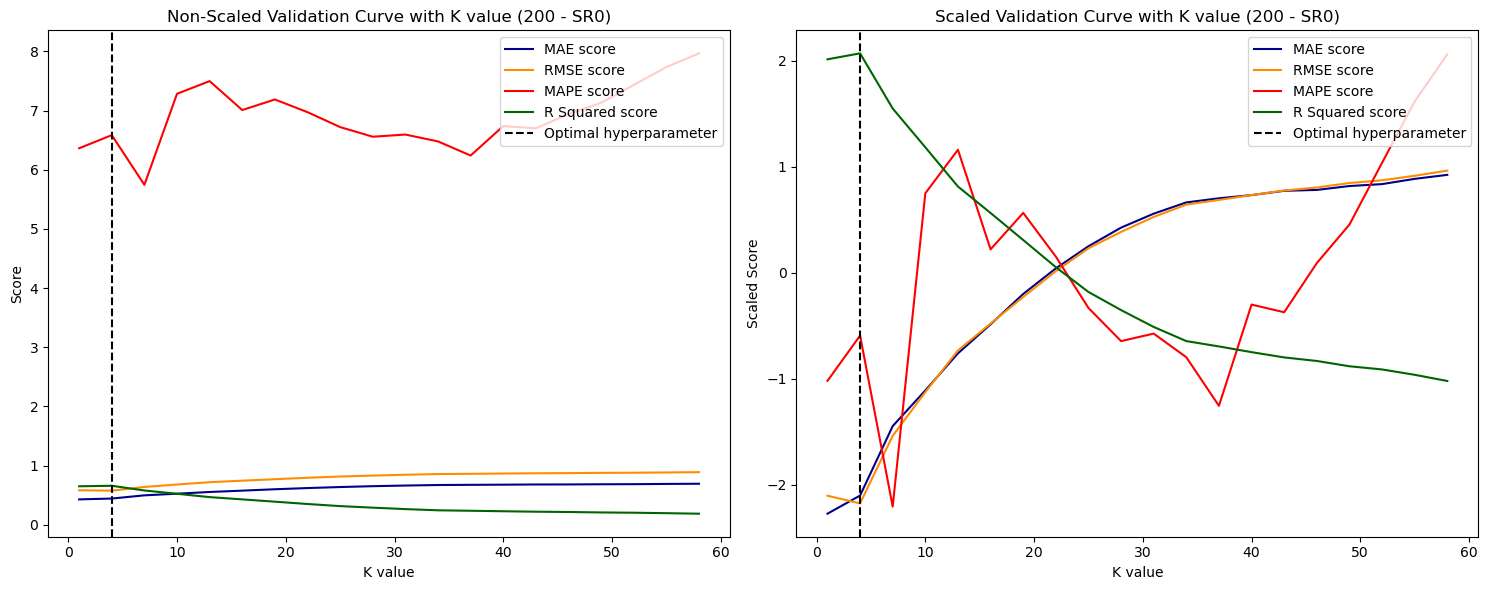

In [8]:
k = 4
df = pd.DataFrame(cv_score_list_200_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (200 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (200 - SR0)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [9]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal400.csv')

In [10]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.317476,0.326826,0.380305,0.416768,0.451591,0.478295,0.495105,0.512759,0.527937,0.543421,0.558405,0.570753,0.582794,0.593313,0.602493,0.612453,0.620976,0.628787,0.634199,0.638870
Validation Score RMSE,0.438789,0.440279,0.499885,0.539153,0.588548,0.623165,0.649141,0.673806,0.694512,0.712283,0.730269,0.743382,0.755869,0.767696,0.779251,0.790305,0.799852,0.807853,0.814926,0.820084
Validation Score MAPE,5.487075,4.081615,6.481709,6.867092,7.303350,7.356194,7.604561,7.808458,7.484084,7.845250,7.959795,7.983418,7.891366,7.640461,7.454478,7.154075,7.365629,7.119584,7.068301,6.854679
Validation Score R Squared,0.801808,0.800460,0.742774,0.700775,0.643436,0.600257,0.566237,0.532649,0.503484,0.477749,0.451041,0.431149,0.411879,0.393330,0.374929,0.357070,0.341444,0.328201,0.316386,0.307705


The smallest Validation Score MAE is 0.3174761651756219, found in K = 1.
The smallest Validation Score RMSE is 0.43878900607072496, found in K = 1.
The smallest Validation Score MAPE is 4.081615480385607, found in K = 4.
The largest Validation Score R Squared is 0.8018083044676063, found in K = 1.
Validation Computation Time: 0.70 seconds


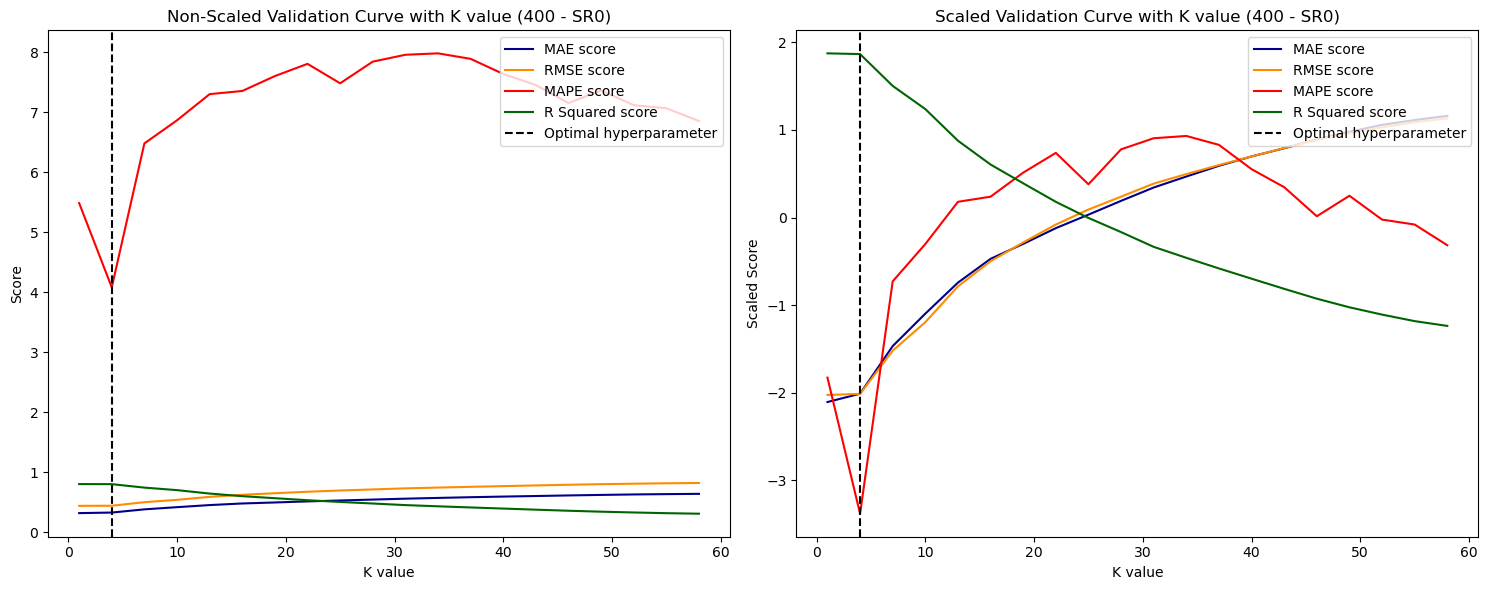

In [12]:
k = 4
df = pd.DataFrame(cv_score_list_400_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (400 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (400 - SR0)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [13]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal600.csv')

In [14]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.266263,0.270821,0.314157,0.357785,0.392359,0.418612,0.444695,0.465926,0.484541,0.500396,0.513867,0.524559,0.534760,0.546117,0.555110,0.563545,0.571165,0.578784,0.586674,0.593588
Validation Score RMSE,0.366857,0.368622,0.416720,0.466409,0.509436,0.543260,0.576188,0.604325,0.631574,0.652643,0.669853,0.683711,0.696282,0.710023,0.721527,0.731743,0.740175,0.748884,0.758161,0.766057
Validation Score MAPE,5.167892,5.266996,5.095960,6.836660,7.704425,7.681014,8.022889,8.047333,8.514233,8.999959,8.887195,8.328779,8.594327,8.749882,8.726957,8.781430,8.754674,8.829212,8.888558,8.900598
Validation Score R Squared,0.861462,0.860126,0.821244,0.776073,0.732851,0.696199,0.658254,0.624063,0.589396,0.561545,0.538115,0.518808,0.500950,0.481059,0.464105,0.448823,0.436047,0.422698,0.408306,0.395917


The smallest Validation Score MAE is 0.2662626652982939, found in K = 1.
The smallest Validation Score RMSE is 0.3668570056552833, found in K = 1.
The smallest Validation Score MAPE is 5.095960100936937, found in K = 7.
The largest Validation Score R Squared is 0.8614624153674735, found in K = 1.
Validation Computation Time: 0.25 seconds


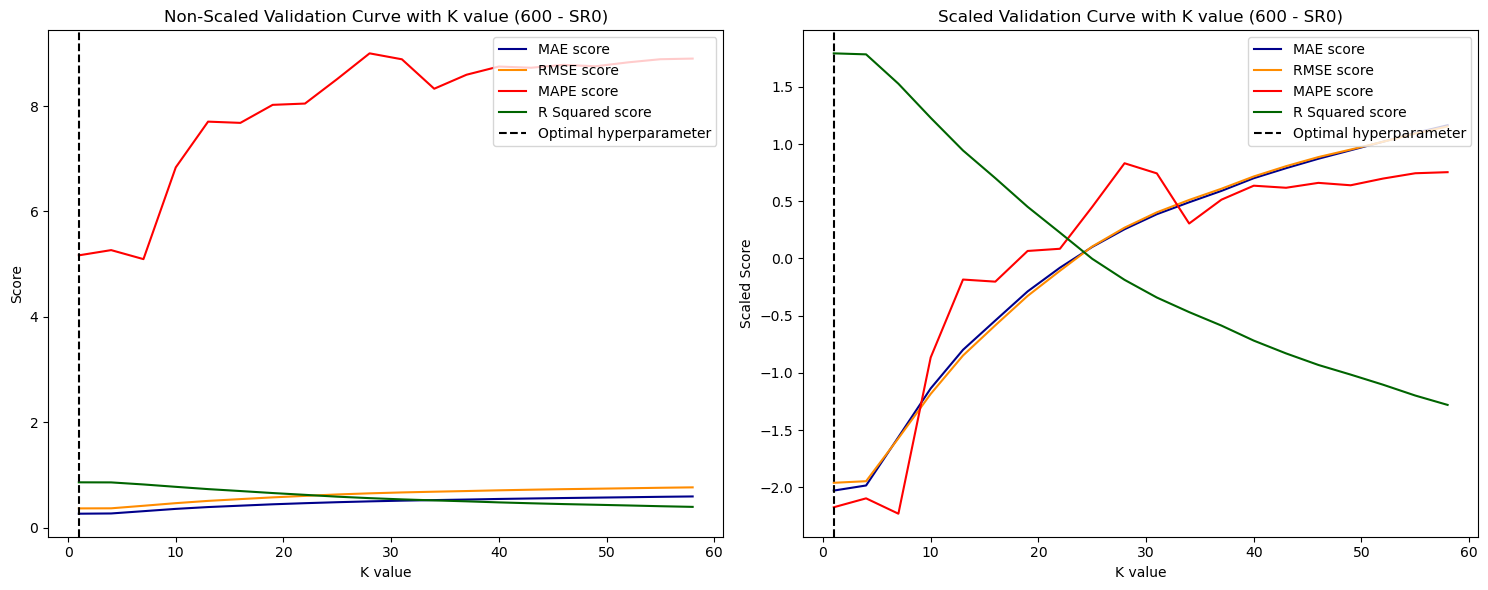

In [17]:
k = 1
df = pd.DataFrame(cv_score_list_600_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (600 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (600 - SR0)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [18]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal800.csv')

In [19]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.240264,0.232977,0.271640,0.310740,0.345420,0.375107,0.397642,0.417997,0.437801,0.456183,0.470380,0.483487,0.495961,0.508359,0.517508,0.524808,0.533292,0.541400,0.548419,0.555424
Validation Score RMSE,0.329252,0.313956,0.361031,0.403624,0.447468,0.485202,0.515097,0.540644,0.566953,0.590603,0.611065,0.628945,0.645377,0.660513,0.672507,0.683269,0.694459,0.705370,0.714085,0.722058
Validation Score MAPE,3.850088,3.253273,4.118199,5.433120,6.386893,7.014004,7.269785,7.178510,7.389331,7.899725,8.101953,8.091270,8.424476,8.236981,8.220005,8.537786,8.279807,8.366380,8.719373,8.677484
Validation Score R Squared,0.888409,0.898536,0.865828,0.832302,0.793890,0.757663,0.726881,0.699118,0.669121,0.640942,0.615631,0.592808,0.571254,0.550907,0.534449,0.519429,0.503559,0.487837,0.475103,0.463317


The smallest Validation Score MAE is 0.23297725382830384, found in K = 4.
The smallest Validation Score RMSE is 0.3139560400345685, found in K = 4.
The smallest Validation Score MAPE is 3.253272896835988, found in K = 4.
The largest Validation Score R Squared is 0.8985360739522741, found in K = 4.
Validation Computation Time: 0.29 seconds


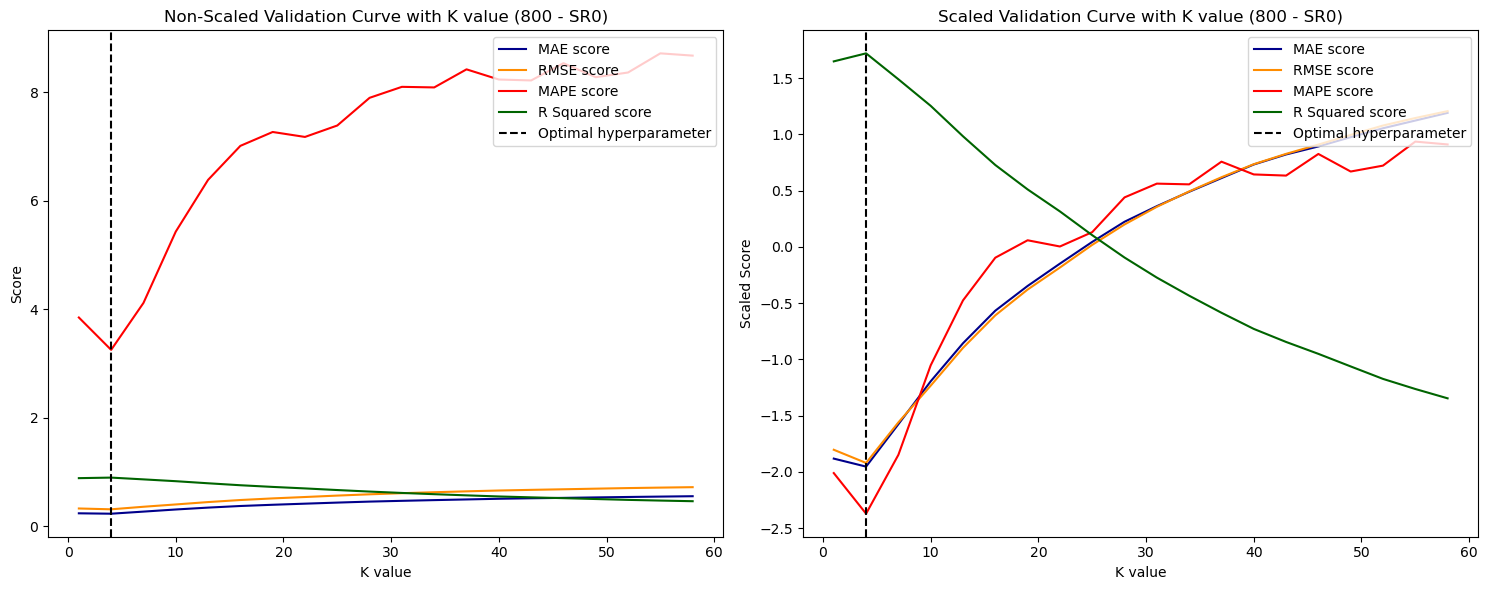

In [20]:
k = 4
df = pd.DataFrame(cv_score_list_800_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (800 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (800 - SR0)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [21]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1000.csv')

In [22]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.218437,0.198459,0.237298,0.275798,0.311188,0.338905,0.363172,0.386639,0.404721,0.419898,0.435923,0.451014,0.463410,0.475611,0.486560,0.497723,0.507003,0.515748,0.522799,0.529989
Validation Score RMSE,0.296338,0.262584,0.311131,0.358297,0.400716,0.436786,0.467668,0.497102,0.520600,0.542177,0.564062,0.583197,0.600072,0.616197,0.631159,0.645021,0.657141,0.668316,0.678421,0.688472
Validation Score MAPE,3.710119,2.166224,3.176516,5.356835,5.966203,6.707298,6.771097,6.851853,7.261009,7.212575,7.735755,7.797824,8.021418,8.093602,8.294799,8.270872,8.273446,8.340466,8.459779,8.482285
Validation Score R Squared,0.909604,0.929024,0.900354,0.867852,0.834709,0.803614,0.774862,0.745630,0.721014,0.697408,0.672487,0.649890,0.629336,0.609147,0.589936,0.571726,0.555480,0.540233,0.526224,0.512082


The smallest Validation Score MAE is 0.19845875388518341, found in K = 4.
The smallest Validation Score RMSE is 0.2625844959648029, found in K = 4.
The smallest Validation Score MAPE is 2.166224082418852, found in K = 4.
The largest Validation Score R Squared is 0.9290238990719153, found in K = 4.
Validation Computation Time: 0.30 seconds


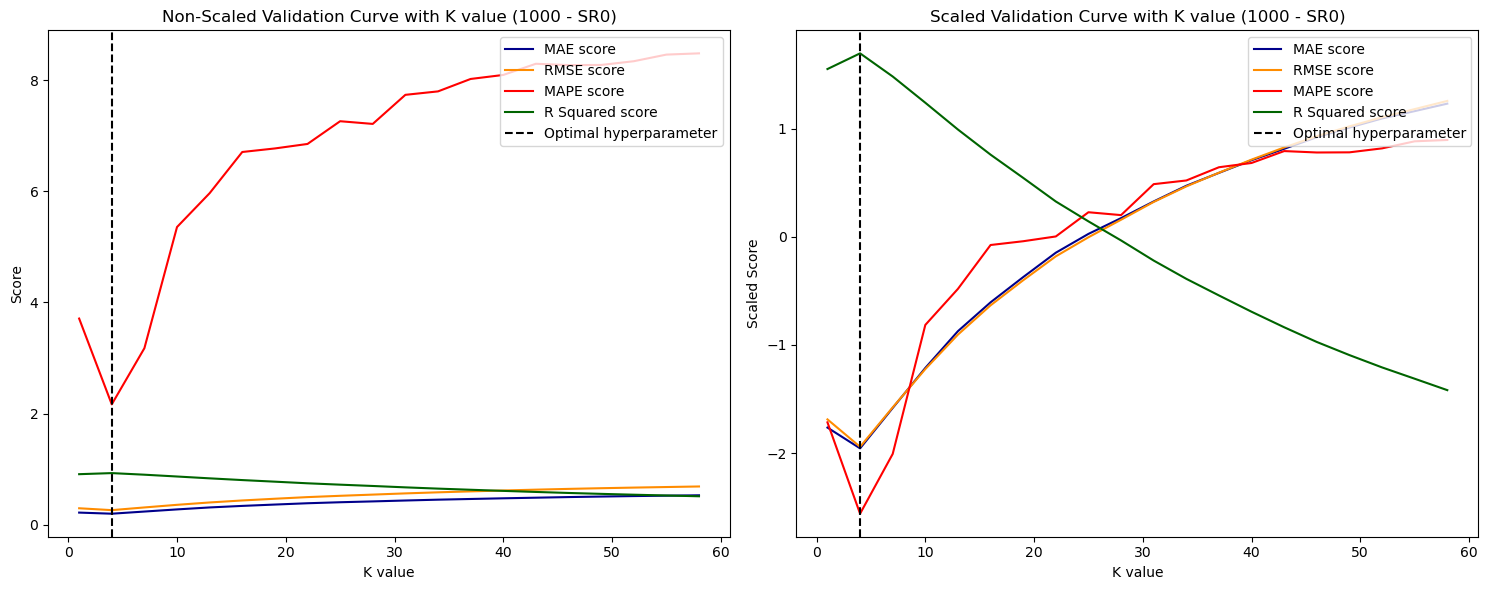

In [23]:
k = 4
df = pd.DataFrame(cv_score_list_1000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1000 - SR0)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [24]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal1500.csv')

In [25]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_1500_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.187868,0.164795,0.191317,0.220383,0.248312,0.273472,0.297282,0.318009,0.338092,0.356135,0.372649,0.386539,0.400071,0.411175,0.421498,0.432255,0.442296,0.452045,0.461228,0.469074
Validation Score RMSE,0.253399,0.224282,0.252007,0.288407,0.320985,0.351142,0.379309,0.405478,0.429440,0.452888,0.474506,0.492838,0.509834,0.524566,0.538843,0.553128,0.566938,0.579202,0.590988,0.601605
Validation Score MAPE,3.131541,2.953522,2.861209,3.535338,4.131131,5.488937,5.599535,5.880789,6.152391,6.377741,6.661624,6.337110,6.733350,6.634930,6.794488,7.139892,7.469848,7.579736,7.659924,7.793723
Validation Score R Squared,0.933902,0.948220,0.934627,0.914378,0.893942,0.873077,0.851899,0.830758,0.810164,0.788867,0.768230,0.749975,0.732434,0.716747,0.701119,0.685062,0.669139,0.654670,0.640474,0.627440


The smallest Validation Score MAE is 0.16479498817599245, found in K = 4.
The smallest Validation Score RMSE is 0.22428220813419045, found in K = 4.
The smallest Validation Score MAPE is 2.8612091725877127, found in K = 7.
The largest Validation Score R Squared is 0.9482198118602123, found in K = 4.
Validation Computation Time: 0.26 seconds


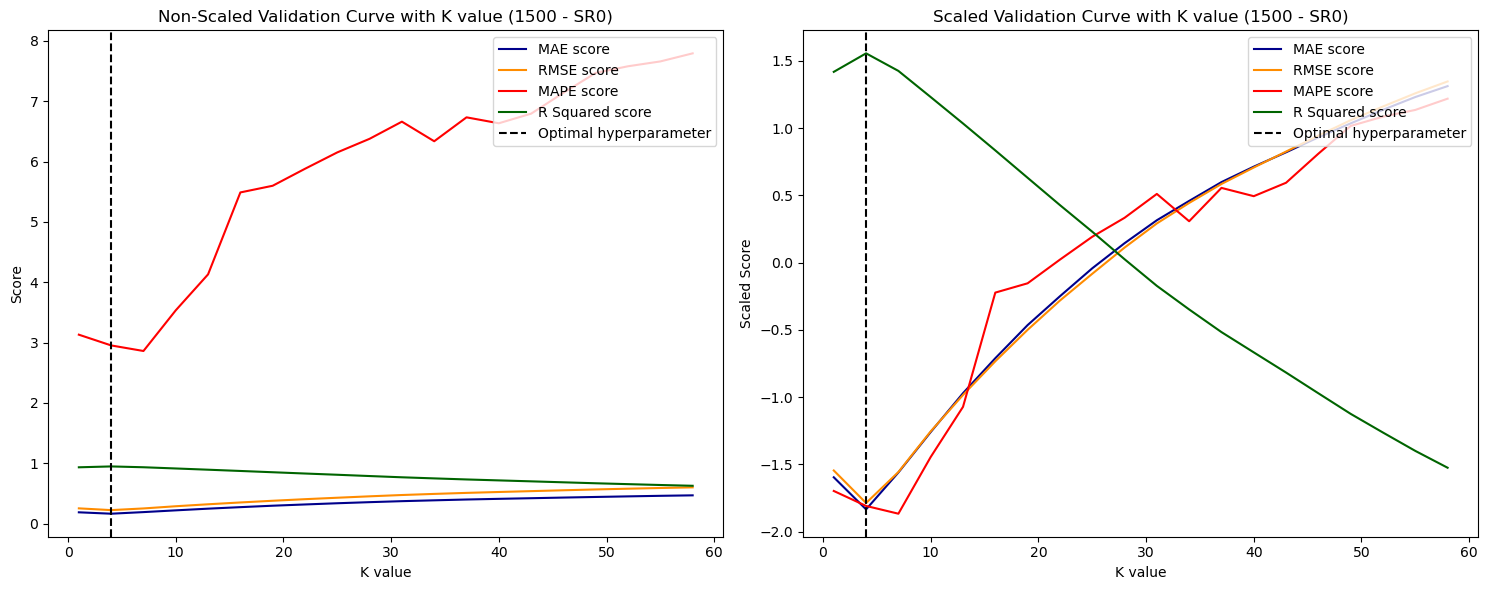

In [26]:
k = 4
df = pd.DataFrame(cv_score_list_1500_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (1500 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (1500 - SR0)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [27]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/SR0/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_SR0_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_SR0_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_SR0_input_randomfield_cal2000.csv')

In [28]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_k = {}
neighbors_range = np.arange(1, 61,3)

start_time = time.time()

# For each hyperparameter value
for k in neighbors_range:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    
    # Instantiate and fit model with calibration data
    nn_model = KNeighborsRegressor(n_neighbors=k)
    nn_model.fit(combined_array_train,cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = nn_model.predict(combined_array_validation)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_k[k] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_k))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_2000_k.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in K = {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in K = {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")

,1,4,7,10,13,16,19,22,25,28,31,34,37,40,43,46,49,52,55,58
Validation Score MAE,0.165472,0.138564,0.159285,0.183768,0.209296,0.232046,0.252485,0.271262,0.288905,0.307238,0.322854,0.337810,0.351930,0.363310,0.376115,0.387478,0.397082,0.406735,0.415728,0.423507
Validation Score RMSE,0.216698,0.186207,0.208817,0.238571,0.268685,0.296770,0.322316,0.343515,0.365812,0.388392,0.407099,0.426337,0.444055,0.459135,0.475609,0.490648,0.503394,0.516568,0.528748,0.539968
Validation Score MAPE,3.236916,1.198644,2.024165,3.560765,2.991345,4.063639,4.551589,5.483150,5.269176,5.691714,5.930862,5.840937,6.077952,6.030156,5.981241,6.099352,6.112755,6.466127,6.694221,6.840046
Validation Score R Squared,0.951663,0.964309,0.955114,0.941412,0.925687,0.909340,0.893061,0.878531,0.862250,0.844721,0.829402,0.812897,0.797023,0.783003,0.767151,0.752193,0.739151,0.725319,0.712213,0.699870


The smallest Validation Score MAE is 0.13856448935191795, found in K = 4.
The smallest Validation Score RMSE is 0.18620655282029785, found in K = 4.
The smallest Validation Score MAPE is 1.1986436328164327, found in K = 4.
The largest Validation Score R Squared is 0.9643085741498156, found in K = 4.
Validation Computation Time: 0.40 seconds


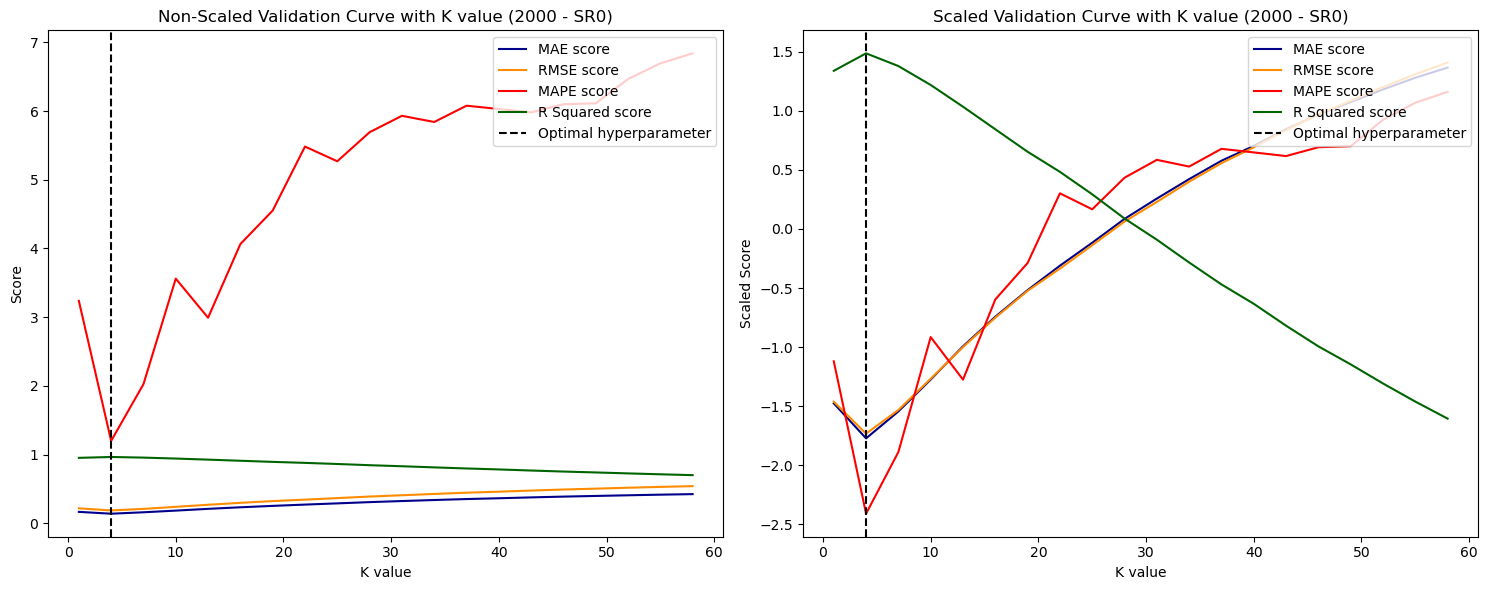

In [30]:
k = 4
df = pd.DataFrame(cv_score_list_2000_k).T

# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(neighbors_range, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(neighbors_range, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(neighbors_range, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(neighbors_range, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('K value')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation Curve with K value (2000 - SR0)")

# Plot normalized data on the second subplot
ax[1].plot(neighbors_range, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(neighbors_range, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(k, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('K value')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation Curve with K value (2000 - SR0)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [31]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_k = [cv_score_list_200_k, cv_score_list_400_k, cv_score_list_600_k, cv_score_list_800_k,cv_score_list_1000_k,
                     cv_score_list_1500_k, cv_score_list_2000_k]

# Calculate means
all_means_k = calculate_means(data_structures_k)

In [32]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_k = replace_keys(all_means_k, new_keys)

In [33]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_k_df = pd.DataFrame(all_means_k).T
all_means_k_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.616821,0.792701,6.893040,0.342920
400,0.524676,0.683453,7.140559,0.504138
600,0.474186,0.618123,7.938949,0.589802
800,0.433240,0.564574,7.172422,0.654349
1000,0.402015,0.521273,6.847499,0.702031
1500,0.342225,0.439489,5.845838,0.786256
2000,0.299544,0.381367,5.007237,0.837215


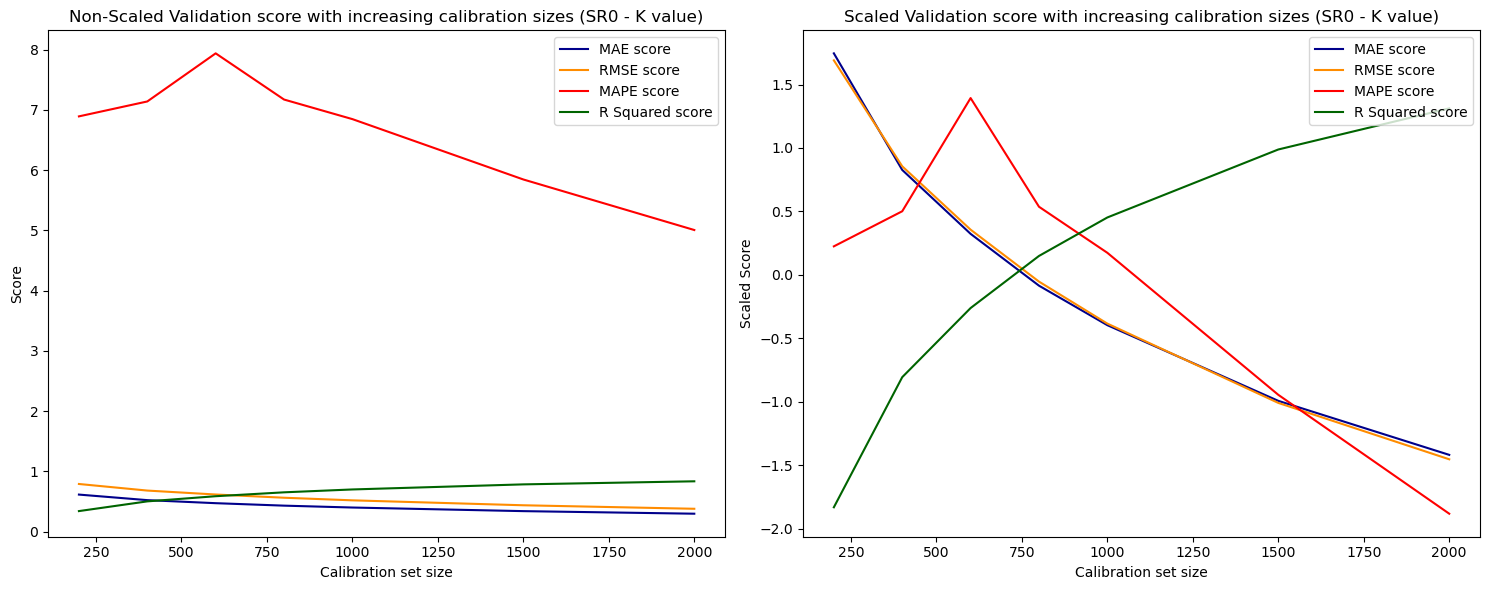

In [34]:
# Initialize MinMaxScaler
scaler = StandardScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_k_df), columns=all_means_k_df.columns, index=all_means_k_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_k_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_k_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Scaled Validation score with increasing calibration sizes (SR0 - K value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Scaled Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Scaled Validation score with increasing calibration sizes (SR0 - K value)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [35]:
filenames = ['SR0_input_randomfield_cal200','SR0_input_randomfield_cal400', 'SR0_input_randomfield_cal600',
             'SR0_input_randomfield_cal800', 'SR0_input_randomfield_cal1000', 'SR0_input_randomfield_cal1500', 'SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/SR0/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-0.520793
1,47,42,-0.373555
2,92,88,0.003110
3,24,43,-0.232004
4,37,92,-0.116758
...,...,...,...
3995,93,12,-3.031762
3996,56,25,0.305903
3997,22,8,-1.150329
3998,38,35,-0.539275


In [40]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

nn_model = KNeighborsRegressor(n_neighbors=4)
nn_model.fit(eval_combined_array_coordinates,combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = nn_model.predict(eval_combined_array_test)
    
mae = mean_absolute_error(test_df['z'], z_pred_test)
rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.08682233442021067
RMSE: 0.12091198419500943
MAPE: 0.45708722505331206
R Squared: 0.9852556776432938
Testing Computation Time: 0.02 seconds


### Plotting Spatial Interpolation of entire area with Model

In [41]:
filenames = ['cal_SR0_input_randomfield_cal200', 'cal_SR0_input_randomfield_cal400', 'cal_SR0_input_randomfield_cal600', 'cal_SR0_input_randomfield_cal800', 'cal_SR0_input_randomfield_cal1000', 'cal_SR0_input_randomfield_cal1500', 'cal_SR0_input_randomfield_cal2000',
            'val_SR0_input_randomfield_cal2000', 'test_SR0_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/SR0/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-0.838066
1,40,74,-0.436379
2,90,28,-0.031699
3,51,84,-0.388236
4,32,48,-1.099538
...,...,...,...
5995,93,12,-3.031762
5996,56,25,0.305903
5997,22,8,-1.150329
5998,38,35,-0.539275


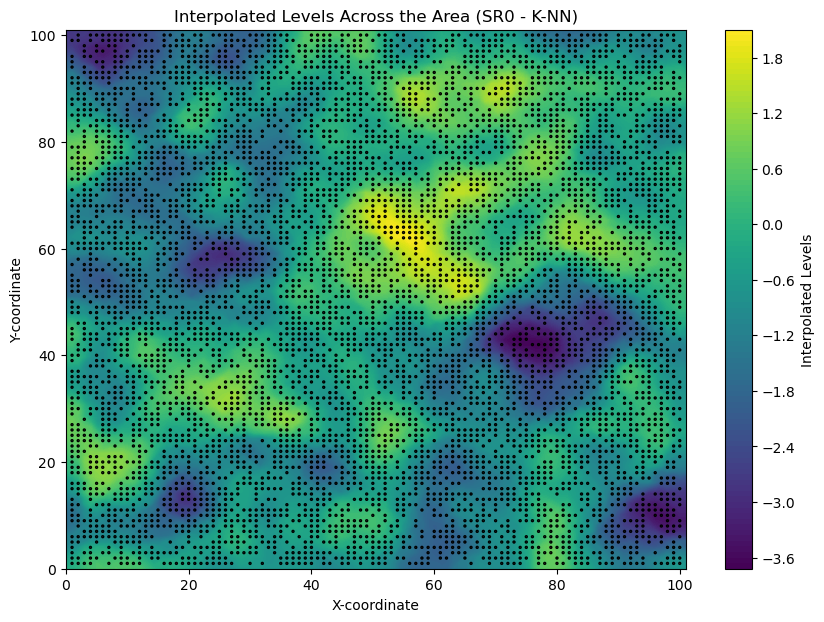

Spatial Interpolation Computation Time: 0.02 seconds


In [43]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
nn_model = KNeighborsRegressor(n_neighbors=4)
nn_model.fit(observed_locations,observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = nn_model.predict(grid_points)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (SR0 - K-NN)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")